In [1]:
# Autor: Jairo Valea López
#
# Cousiñas con machine learning aplicado á niebla do Fiouco

# Importado de librerías habituales

import os
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
import time
import natsort
import csv
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn import metrics
from IPython.utils import io
from natsort import natsorted
from tqdm.notebook import tqdm, trange # barra de progreso
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance

%matplotlib notebook

def promedio(lst):
    return sum(lst) / len(lst)

# cargado de datos (todo.csv)

ruta_proces = 'C:\\Users\\miguel.anton\\Desktop\\NIEBLA\\Ensayos procesados\\'

carpeta = natsorted(os.listdir(ruta_proces))
procesados = []
nombres = []

# Valor máximo de visibilidad a considerar
# los algoritmos funcionan mejor con un valor máximo más bajo (100)
tope = 150

datos = pd.read_csv(ruta_proces + 'todo.csv', delimiter = ";", decimal = ".")
for i in range(len(datos)):
    if (datos.loc[i,'vis'] > tope):
        datos.loc[i,'vis'] = tope
datos = pd.get_dummies(datos, columns=["dir_v_estacion"], prefix=["dir"] )

dx = [0.007,0.008,0.009,0.009,0.01,0.011,0.011,0.012,0.013,0.014,0.015,0.016,0.018,0.019,0.02,0.022,0.024,0.025,0.027
,0.029,0.031,0.034,0.036,0.039,0.042,0.045,0.048,0.052,0.056,0.06,0.065,0.069,0.075,0.08,0.086,0.093,0.099,0.107,0.115
,0.123,0.133,0.143,0.153,0.165,0.177,0.19,0.204,0.22,0.236,0.254,0.272,0.293,0.315,0.338,0.363,0.39,0.42,0.451,0.484
,0.521,0.559,0.601,0.646,0.694,0.746,0.802,0.862,0.926,0.995,1.069,1.149,1.235,1.327]



In [100]:
# 
# PREDICCIÓN: INTENTAR PREDECIR LA VISIBILIDAD A PARTIR DE LOS DATOS DISPONIBLES
# USANDO DIFERENTES ALGORITMOS DE MACHINE-LEARNING:
#
# Random forest: n-ización de árboles de decisión (entiéndase como una especie de diagrama de flujo)
# Gradient booster: conjunción y retroalimentación de modelos de predicción débiles por si solos
#

posiciones = [1,3,4,5,6,7,8,11]
#posiciones = [1,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19]
#posiciones = [4,7] # solo D_sauter y concentración
X = datos.iloc[:, posiciones].values
y = datos.iloc[:, 10].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# evitar diferencias de escala
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# random forest
bosque = RandomForestRegressor(n_estimators=200,random_state=0,min_samples_split=5,min_samples_leaf=2,max_depth=50,bootstrap=True)
bosque.fit(X_train, y_train)
y_pred_bosque = bosque.predict(X_test)

# gradient booster
boost = AdaBoostRegressor(n_estimators=200, learning_rate=0.1,random_state=0,loss='square')
boost.fit(X_train, y_train)
y_pred_gradient = boost.predict(X_test)

print('')
print('          Bosque aleatorio:')
print('')
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_bosque)),3))
print('           visi real     -      visi pred')
for i in range(len(y_test)):
    print("{: >20} {: >20}".format(y_test[i], round(y_pred_bosque[i],2)))
print('')
print('')
print('               Ada booster:')
print('')
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_gradient)),3))
print('           visi real     -      visi pred')
for i in range(len(y_test)):
    print("{: >20} {: >20}".format(y_test[i], round(y_pred_gradient[i],2)))


          Bosque aleatorio:

Root Mean Squared Error: 37.671
           visi real     -      visi pred
               150.0                132.0
                76.0                97.47
                49.0                91.05
                30.0                39.13
               132.0                48.24
                20.0                23.96
                38.0                40.02
                37.0                42.41
                54.0                58.39
               109.0                102.9
                31.0                32.14
                41.0                36.73
                29.0                 34.3
                26.0                29.19
                18.0                20.41
                21.0                20.61
                41.0                34.93
               150.0                 84.8
                32.0                145.9
                35.0                39.69
                37.0                46.41
              

In [101]:
s_bosque = cross_val_score(bosque, X, y, cv=10, scoring='neg_root_mean_squared_error')
s_boost = cross_val_score(boost, X, y, cv=10, scoring='neg_root_mean_squared_error')

print('Al bosque aleatorio le importan las siguientes variables:') # 30.94 con todas  30.50 sin viento y dmedio
                                                                    # 30.24 con solo dsauter, d10, d90 y temp
                                                                    # 29.53 con solo dsauter, d10, d90 y dmedio
                                                                    # 28.13 añadiendo día del año
print("%0.2f accuracy with a standard deviation of %0.2f" % (s_bosque.mean(), s_bosque.std()))
print('')
r = permutation_importance(bosque, X_test, y_test, n_repeats=20, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    print(f"{datos.columns[posiciones[i]]:<12}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")
print('')
print('Al Ada booster le importan las siguientes variables:')
print("%0.2f accuracy with a standard deviation of %0.2f" % (s_boost.mean(), s_boost.std()))
print('')
r = permutation_importance(boost, X_test, y_test, n_repeats=20, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    print(f"{datos.columns[posiciones[i]]:<12}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

Al bosque aleatorio le importan las siguientes variables:
-31.60 accuracy with a standard deviation of 12.27

d_sauter    0.327 +/- 0.137
dia         0.153 +/- 0.063
temp        0.136 +/- 0.033
d10         0.016 +/- 0.013
d90         -0.019 +/- 0.031
concentr    -0.020 +/- 0.016
LWC         -0.025 +/- 0.026
d_medio     -0.029 +/- 0.029

Al Ada booster le importan las siguientes variables:
-32.44 accuracy with a standard deviation of 10.58

d_sauter    0.307 +/- 0.153
temp        0.111 +/- 0.045
dia         0.099 +/- 0.051
d10         0.026 +/- 0.009
LWC         0.004 +/- 0.008
d_medio     -0.005 +/- 0.014
concentr    -0.015 +/- 0.009
d90         -0.033 +/- 0.072


<IPython.core.display.Javascript object>


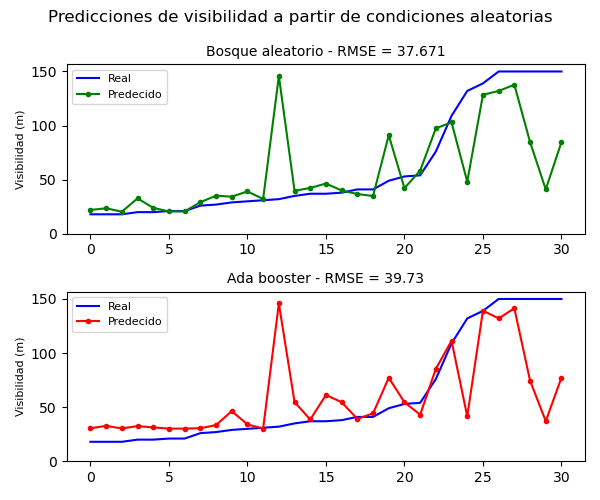

In [102]:
equis = range(len(y_test))

void = pd.DataFrame(y_test)
ind = void.sort_values(by=0).index
void = []

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,5))

plt.suptitle("Predicciones de visibilidad a partir de condiciones aleatorias")

ax1.plot(equis,y_test[ind], color = "blue",label="Real")
ax1.plot(equis, y_pred_bosque[ind], color = "green", marker = ".",label="Predecido")
ax1.set_ylim(bottom=0)
ax1.set_ylabel("Visibilidad (m)",size=8)
ax1.set_title('Bosque aleatorio - RMSE = ' + str(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_bosque)),3)),size=10)
ax1.legend(loc="upper left",prop={'size': 8})

ax2.plot(equis,y_test[ind], color = "blue",label="Real")
ax2.plot(equis, y_pred_gradient[ind], color = "red", marker = ".",label="Predecido")
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Visibilidad (m)",size=8)
ax2.set_title('Ada booster - RMSE = ' + str(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_gradient)),3)),size=10)
ax2.legend(loc="upper left",prop={'size': 8})

fig.tight_layout()
plt.show()

In [93]:
#
# A partir exclusivamente de la granulometría:
#
        
for f in carpeta:
    name, ext = os.path.splitext(f)
    if ext == '.txt':
        procesados.append(pd.read_csv(ruta_proces + name + ext, delimiter = ",", decimal = "."))
        nombres.append(name + ext)

procesados_total = pd.concat(procesados,ignore_index = True)
procesados_total = procesados_total.apply(lambda col:pd.to_numeric(col, errors='coerce'))
procesados_total = procesados_total.dropna()
procesados_total = procesados_total[procesados_total['Visibilidad corregida (m)'] != 0]
procesados_total.reset_index(drop=True, inplace=True)

tope = 150

for i in range(len(procesados_total)):
    if (procesados_total.loc[i,'Visibilidad corregida (m)'] > tope):
        procesados_total.loc[i,'Visibilidad corregida (m)'] = tope

posiciones = [18,22,26,30,34,38,42,46,50,54,58,62,66,70,74]
#posiciones = np.linspace(25,75,26)
#posiciones = np.linspace(1,75,38)
#posiciones2 = np.linspace(1,75,75) # todo
X2 = procesados_total.iloc[:, posiciones].values
y2 = procesados_total.iloc[:, procesados_total.shape[1]-1].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3)

sc = StandardScaler()
X_train2 = sc.fit_transform(X_train2)
X_test2 = sc.transform(X_test2)

# random forest
bosque2 = RandomForestRegressor(n_estimators=200,random_state=0,min_samples_split=5,min_samples_leaf=2,max_depth=50,bootstrap=True)
bosque2.fit(X_train2, y_train2)
y_pred2 = bosque2.predict(X_test2)

print('')
print('          Bosque aleatorio:')
print('')
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)),3))
print('           visi real     -      visi pred')
for i in range(25):
    print("{: >20} {: >20}".format(y_test2[i], round(y_pred2[i],2)))
print('')


          Bosque aleatorio:

Root Mean Squared Error: 15.124
           visi real     -      visi pred
                61.0                52.31
                50.0                63.57
               150.0               113.95
                25.0                29.22
                29.0                47.03
               150.0               149.45
                15.0                26.97
                50.0                45.69
                60.0                84.62
                40.0                40.43
                40.0                40.16
                28.0                32.09
                67.0                48.85
                30.0                32.46
                24.0                27.64
                35.0                34.87
                38.0                38.25
               135.0                69.43
               150.0                150.0
                65.0                65.28
                53.0                61.27
              

In [95]:
s_granos = cross_val_score(bosque2, X2, y2, cv=10, scoring='neg_root_mean_squared_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (s_granos.mean(), s_granos.std()))
print('')
print('Al bosque aleatorio le importan las siguientes variables:')
print('')
r = permutation_importance(bosque2, X_test2, y_test2, n_repeats=20, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    print(f"{procesados_total.columns[posiciones[i]]:<12}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")
print('')

-10.27 accuracy with a standard deviation of 1.96

Al bosque aleatorio le importan las siguientes variables:

0.407       0.342 +/- 0.008
9.653       0.241 +/- 0.006
0.965       0.216 +/- 0.006
5.428       0.181 +/- 0.006
0.724       0.169 +/- 0.007
1.287       0.077 +/- 0.004
4.071       0.065 +/- 0.004
0.543       0.054 +/- 0.002
7.239       0.052 +/- 0.002
12.872      0.041 +/- 0.003
2.289       0.030 +/- 0.002
17.165      0.026 +/- 0.003
3.053       0.018 +/- 0.001
1.717       0.014 +/- 0.001
0.305       0.000 +/- 0.000



<IPython.core.display.Javascript object>


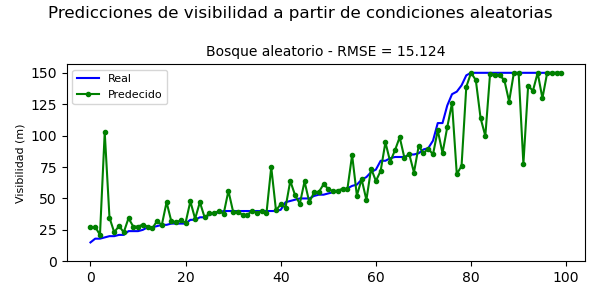

In [96]:
equis = range(len(y_test2))

fig2, ax = plt.subplots(1,1, figsize=(6,3))

plt.suptitle("Predicciones de visibilidad a partir de condiciones aleatorias")

void = pd.DataFrame(y_test2[0:100])
ind = void.sort_values(by=0).index
void = []

ax.plot(equis[0:100],y_test2[ind], color = "blue",label="Real")
ax.plot(equis[0:100], y_pred2[ind], color = "green", marker = ".",label="Predecido")
ax.set_ylim(bottom=0)
ax.set_ylabel("Visibilidad (m)",size=8)
ax.set_title('Bosque aleatorio - RMSE = ' + str(round(np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)),3)),size=10)
ax.legend(loc="upper left",prop={'size': 8})

fig2.tight_layout()
plt.show()

In [333]:
ruta_proces = 'C:\\Users\\miguel.anton\\Desktop\\NIEBLA\\Ensayos procesados\\'

carpeta = natsorted(os.listdir(ruta_proces))
procesados = []
nombres = []

for f in carpeta:
    name, ext = os.path.splitext(f)
    if ext == '.txt':
        procesados.append(pd.read_csv(ruta_proces + name + ext, delimiter = ",", decimal = "."))
        nombres.append(name + ext)

diams_f = procesados[0].iloc[60,3:45] # vectores con los tamaños de partícula (separados en finos y gruesos)
diams_g = procesados[0].iloc[60,45:76]
diams = procesados[0].iloc[60,3:76]

for i in range(len(nombres)):
    procesados[i] = procesados[i].apply(lambda col:pd.to_numeric(col, errors='coerce'))
    procesados[i]['Ensayo'] = nombres[i][6:-14]

procesados_total = pd.concat(procesados,ignore_index = True)

g = open(ruta_proces + 'database_todo.csv', 'w', encoding='UTF8', newline='')
writer = csv.writer(g, delimiter=';')
writer.writerow(procesados_total.columns)
for i in range(len(procesados_total)):
    writer.writerow(procesados_total.iloc[i,:])
g.close()

  0%|          | 0/1224 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


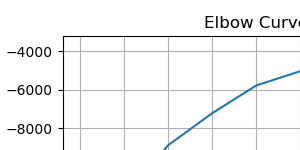

In [382]:
vols = (np.pi/8)*(diams**3)

procesados_total = pd.read_csv(ruta_proces + 'database_modif.csv', delimiter = ';', decimal = '.')

procesados_total = procesados_total.dropna()
procesados_total = procesados_total[procesados_total['Visibilidad corregida (m)'] != 0]
procesados_total = procesados_total[procesados_total['Visibilidad corregida (m)'] < 301]
procesados_total = procesados_total[procesados_total['Temp_est'] > -999]
#procesados_total.reset_index(drop=True, inplace=True)

for j in (trange(len(procesados_total))):
    procesados_total.iloc[j,11:84] = (vols)*(np.divide(procesados_total.iloc[j,11:84],dx))

posiciones = [53,58,62,65,68,70,72,74,76,78,80,5]
#posiciones = [72,74,76,74,74,74,74,74,74,74,74,5]

X = procesados_total.iloc[:, posiciones].values
y = procesados_total.iloc[:, 77].values

sc = StandardScaler()
X = sc.fit_transform(X)

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
ax.grid(True)
plt.show()

In [379]:
nc = 4

kmeans = KMeans(n_clusters=nc).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X)

procesados_total['Tipo'] = labels

color_labels = natsorted(procesados_total['Tipo'].unique())
rgb_values = sns.color_palette("hls", len(color_labels))
colorinchos = ListedColormap(sns.color_palette(rgb_values).as_hex())
color_map = dict(zip(color_labels, rgb_values))

hand = []
for i in range(len(rgb_values)):
    hand.append(mpatches.Patch(color=rgb_values[i], label='Tipo_'+str(color_labels[i])))

In [2]:
for i in range(nc):
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(3, 5, height_ratios = [1, 1, 1], width_ratios = [1,1,1,1,1])
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[0,2])
    ax4 = plt.subplot(gs[1,0])
    ax5 = plt.subplot(gs[1,1])
    ax6 = plt.subplot(gs[1,2])
    ax7 = plt.subplot(gs[2,0])
    ax8 = plt.subplot(gs[2,1])
    ax9 = plt.subplot(gs[2,2])
    ax10 = plt.subplot(gs[0:2,3:5])
    ax11 = plt.subplot(gs[2,3])
    ax12 = plt.subplot(gs[2,4])
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.5)

    pt = procesados_total
    pt = procesados_total[procesados_total['Tipo'] == i]
    ax1.scatter(pt.iloc[:,posiciones[0]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])
    ax2.scatter(pt.iloc[:,posiciones[1]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])
    ax3.scatter(pt.iloc[:,posiciones[2]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])
    ax4.scatter(pt.iloc[:,posiciones[3]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])
    ax5.scatter(pt.iloc[:,posiciones[4]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])
    ax6.scatter(pt.iloc[:,posiciones[5]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])
    ax7.scatter(pt.iloc[:,posiciones[6]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])
    ax8.scatter(pt.iloc[:,posiciones[7]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])
    ax9.scatter(pt.iloc[:,posiciones[8]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])
    ax11.scatter(pt.iloc[:,posiciones[9]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])
    ax12.scatter(pt.iloc[:,posiciones[10]],pt.iloc[:,85], alpha = 0.3, marker='.', color = color_map[i])

    ax10.scatter(pt.iloc[:,posiciones[11]],pt.iloc[:,85], alpha = 0.5, marker='.', color = color_map[i])
    
    ax1.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[0]].name)
    ax1.set_ylabel('visib (m)')
    ax2.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[1]].name)
    ax2.set_ylabel('visib (m)')
    ax3.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[2]].name)
    ax3.set_ylabel('visib (m)')
    ax4.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[3]].name)
    ax4.set_ylabel('visib (m)')
    ax5.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[4]].name)
    ax5.set_ylabel('visib (m)')
    ax6.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[5]].name)
    ax6.set_ylabel('visib (m)')
    ax7.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[6]].name)
    ax7.set_ylabel('visib (m)')
    ax8.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[7]].name)
    ax8.set_ylabel('visib (m)')
    ax9.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[8]].name)
    ax9.set_ylabel('visib (m)')
    ax11.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[9]].name)
    ax11.set_ylabel('visib (m)')
    ax12.set_xlabel('ug/cm3, D = ' + pt.iloc[:,posiciones[10]].name)
    ax12.set_ylabel('visib (m)')

    ax10.set_xlabel('Temp')
    ax10.set_ylabel('visib (m)')
    ax10.legend(handles=hand, loc = 'upper right')

    limu = 15000
    
    ax1.set_xlim(0,limu); ax1.set_ylim(0,300); 
    ax2.set_xlim(0,limu); ax2.set_ylim(0,300); 
    ax3.set_xlim(0,limu); ax3.set_ylim(0,300); 
    ax4.set_xlim(0,limu); ax4.set_ylim(0,300); 
    ax5.set_xlim(0,limu); ax5.set_ylim(0,300); 
    ax6.set_xlim(0,limu); ax6.set_ylim(0,300); 
    ax7.set_xlim(0,limu); ax7.set_ylim(0,300); 
    ax8.set_xlim(0,limu); ax8.set_ylim(0,300); 
    ax9.set_xlim(0,limu); ax9.set_ylim(0,300); 
    ax10.set_xlim(10,20); ax10.set_ylim(0,300);
    ax11.set_xlim(0,limu); ax11.set_ylim(0,300); 
    ax12.set_xlim(0,limu); ax12.set_ylim(0,300); 

    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax4.grid(True)
    ax5.grid(True)
    ax6.grid(True)
    ax7.grid(True)
    ax8.grid(True)
    ax9.grid(True)
    ax10.grid(True)
    ax11.grid(True)
    ax12.grid(True)
    plt.tight_layout()
    plt.savefig(ruta_proces + 'clustering1_' + str(i) + '.png')
    plt.show()

NameError: name 'nc' is not defined

In [381]:
for i in range(nc):
    Xc = X[procesados_total['Tipo'] == i]
    yc = y[procesados_total['Tipo'] == i]

    X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.2)

    bosque = RandomForestRegressor(n_estimators=200,random_state=0,min_samples_split=5,min_samples_leaf=2,max_depth=50,bootstrap=True)
    bosque.fit(X_train, y_train)
    y_pred_bosque = bosque.predict(X_test)
    
    s_bosque = cross_val_score(bosque, Xc, yc, cv=10, scoring='neg_root_mean_squared_error')
    print('NIEBLA TIPO',i, '\n')
    print('Al bosque aleatorio le importan las siguientes variables:') # 30.94 con todas  30.50 sin viento y dmedio
                                                                        # 30.24 con solo dsauter, d10, d90 y temp
                                                                        # 29.53 con solo dsauter, d10, d90 y dmedio
                                                                        # 28.13 añadiendo día del año
    print("%0.2f accuracy with a standard deviation of %0.2f" % (s_bosque.mean(), s_bosque.std()))
    print('')
    r = permutation_importance(bosque, X_test, y_test, n_repeats=20, random_state=0)
    for i in r.importances_mean.argsort()[::-1]:
        print(f"{procesados_total.columns[posiciones[i]]:<12}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")
    print('')

NIEBLA TIPO 0 

Al bosque aleatorio le importan las siguientes variables:
-954.61 accuracy with a standard deviation of 861.21

7.239       0.295 +/- 0.137
Temp_est    0.173 +/- 0.093

NIEBLA TIPO 1 

Al bosque aleatorio le importan las siguientes variables:
-1478.81 accuracy with a standard deviation of 1285.53

Temp_est    1.170 +/- 0.169
7.239       0.637 +/- 0.179

NIEBLA TIPO 2 

Al bosque aleatorio le importan las siguientes variables:
-1415.94 accuracy with a standard deviation of 3657.15

Temp_est    0.348 +/- 0.122
7.239       -0.012 +/- 0.020

NIEBLA TIPO 3 

Al bosque aleatorio le importan las siguientes variables:
-913.16 accuracy with a standard deviation of 697.54

Temp_est    1.568 +/- 0.448
7.239       0.568 +/- 0.332



C:\Users\miguel.anton\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<IPython.core.display.Javascript object>


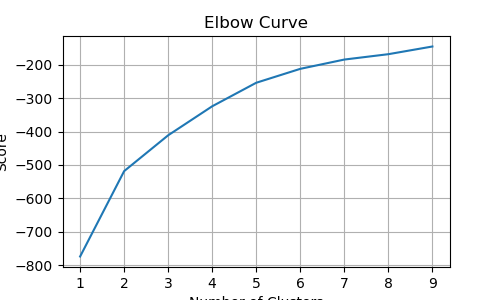

In [119]:
#
# CLASIFICACIÓN: CLASIFICAR LAS "NIEBLAS-FIOUCO" EN CLUSTERS
# USANDO DIFERENTES ALGORITMOS DE MACHINE-LEARNING:
# 
# K-means clustering: 
#

# cargado de datos (ensayos procesados)
# OBLIGATORIO

ruta_proces = 'C:\\Users\\miguel.anton\\Desktop\\NIEBLA\\Ensayos procesados\\'

carpeta = natsorted(os.listdir(ruta_proces))
procesados = []
nombres = []

datos = pd.read_csv(ruta_proces + 'todo.csv', delimiter = ";", decimal = ".")
datos = pd.get_dummies(datos, columns=["dir_v_estacion"], prefix=["dir"] )
datos.drop(datos[datos.vis > 500].index, inplace=True)
datos.reset_index(drop=True, inplace=True)

#posiciones = [4,5,6,11]
posiciones = [3,4,5,6,8,11]
#posiciones = [1,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19]
#posiciones = [4,7] # solo D_sauter y concentración
X = datos.iloc[:, posiciones].values
y = datos.iloc[:, 10].values

sc = StandardScaler()
X = sc.fit_transform(X)

Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
ax.grid(True)
plt.show()

In [120]:
nc = 3

kmeans = KMeans(n_clusters=nc).fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(X)

datos['Tipo'] = labels

color_labels = natsorted(datos['Tipo'].unique())
rgb_values = sns.color_palette("hls", len(color_labels))
colorinchos = ListedColormap(sns.color_palette(rgb_values).as_hex())
color_map = dict(zip(color_labels, rgb_values))

hand = []
for i in range(len(rgb_values)):
    hand.append(mpatches.Patch(color=rgb_values[i], label='Tipo_'+str(color_labels[i])))

<IPython.core.display.Javascript object>


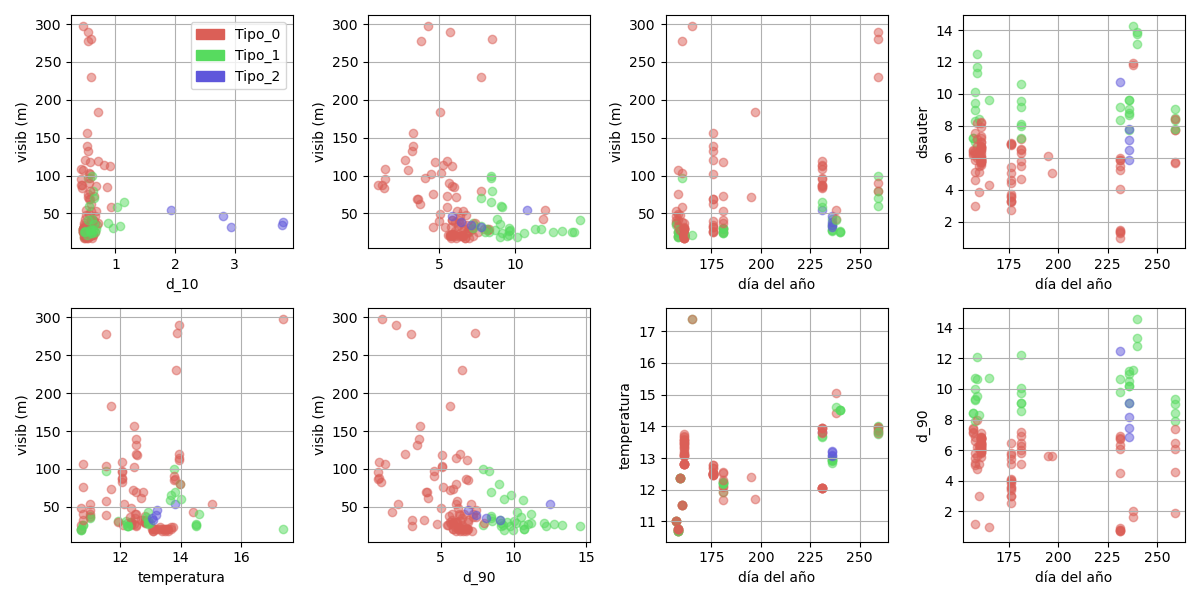

In [121]:
fig, ([ax1,ax2,ax5,ax6],[ax3,ax4,ax7,ax8]) = plt.subplots(2,4,figsize=(12,6))
for i in range(len(datos)):
    ax1.scatter(datos.iloc[i][5],datos.iloc[i][10], alpha = 0.5, marker='o', color = datos['Tipo'].map(color_map)[i])
    ax2.scatter(datos.iloc[i][4],datos.iloc[i][10], alpha = 0.5, marker='o', color = datos['Tipo'].map(color_map)[i])
    ax3.scatter(datos.iloc[i][11],datos.iloc[i][10], alpha = 0.5, marker='o', color = datos['Tipo'].map(color_map)[i])
    ax4.scatter(datos.iloc[i][6],datos.iloc[i][10], alpha = 0.5, marker='o', color = datos['Tipo'].map(color_map)[i])
    ax5.scatter(datos.iloc[i][1],datos.iloc[i][10], alpha = 0.5, marker='o', color = datos['Tipo'].map(color_map)[i])
    ax6.scatter(datos.iloc[i][1],datos.iloc[i][4], alpha = 0.5, marker='o', color = datos['Tipo'].map(color_map)[i])
    ax7.scatter(datos.iloc[i][1],datos.iloc[i][11], alpha = 0.5, marker='o', color = datos['Tipo'].map(color_map)[i])
    ax8.scatter(datos.iloc[i][1],datos.iloc[i][6], alpha = 0.5, marker='o', color = datos['Tipo'].map(color_map)[i])
ax1.set_xlabel('d_10')
ax1.set_ylabel('visib (m)')
ax2.set_xlabel('dsauter')
ax2.set_ylabel('visib (m)')
ax3.set_xlabel('temperatura')
ax3.set_ylabel('visib (m)')
ax4.set_xlabel('d_90')
ax4.set_ylabel('visib (m)')
ax5.set_xlabel('día del año')
ax6.set_xlabel('día del año')
ax7.set_xlabel('día del año')
ax8.set_xlabel('día del año')
ax5.set_ylabel('visib (m)')
ax6.set_ylabel('dsauter')
ax7.set_ylabel('temperatura')
ax8.set_ylabel('d_90')
ax1.legend(handles=hand, loc = 'upper right')
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)
ax5.grid(True)
ax6.grid(True)
ax7.grid(True)
ax8.grid(True)
plt.tight_layout()
plt.savefig(ruta_proces + 'clustering2.png')
plt.show()

In [121]:
for i in range(nc):
    Xc = X[datos['Tipo'] == i]
    yc = y[datos['Tipo'] == i]

    X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.2)

    bosque = RandomForestRegressor(n_estimators=200,random_state=0,min_samples_split=5,min_samples_leaf=2,max_depth=50,bootstrap=True)
    bosque.fit(X_train, y_train)
    y_pred_bosque = bosque.predict(X_test)
    
    s_bosque = cross_val_score(bosque, Xc, yc, cv=10, scoring='neg_root_mean_squared_error')
    print('NIEBLA TIPO',i, '\n')
    print('Al bosque aleatorio le importan las siguientes variables:') # 30.94 con todas  30.50 sin viento y dmedio
                                                                        # 30.24 con solo dsauter, d10, d90 y temp
                                                                        # 29.53 con solo dsauter, d10, d90 y dmedio
                                                                        # 28.13 añadiendo día del año
    print("%0.2f accuracy with a standard deviation of %0.2f" % (s_bosque.mean(), s_bosque.std()))
    print('')
    r = permutation_importance(bosque, X_test, y_test, n_repeats=20, random_state=0)
    for i in r.importances_mean.argsort()[::-1]:
        print(f"{datos.columns[posiciones[i]]:<12}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")
    print('')

KeyError: 'Tipo'